In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import statsmodels as sm
import seaborn as sns
import os
import warnings
import pandas_profiling as pp
import math

In [2]:
warnings.filterwarnings('ignore')
os.chdir('C:/Users/tmutengwa/Documents/Acadgild/DataSources')

In [3]:
train_df = pd.read_csv('adult.data', header = None)
test_df = pd.read_csv('adult.test', skiprows = 1, header = None)

### EDA

In [4]:
train_df.head(), test_df.head()

(   0                  1       2           3   4                    5   \
 0  39          State-gov   77516   Bachelors  13        Never-married   
 1  50   Self-emp-not-inc   83311   Bachelors  13   Married-civ-spouse   
 2  38            Private  215646     HS-grad   9             Divorced   
 3  53            Private  234721        11th   7   Married-civ-spouse   
 4  28            Private  338409   Bachelors  13   Married-civ-spouse   
 
                    6               7       8        9     10  11  12  \
 0        Adm-clerical   Not-in-family   White     Male  2174   0  40   
 1     Exec-managerial         Husband   White     Male     0   0  13   
 2   Handlers-cleaners   Not-in-family   White     Male     0   0  40   
 3   Handlers-cleaners         Husband   Black     Male     0   0  40   
 4      Prof-specialty            Wife   Black   Female     0   0  40   
 
                13      14  
 0   United-States   <=50K  
 1   United-States   <=50K  
 2   United-States   <=50K 

In [5]:
col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'income']


In [6]:
train_df.columns = col_names
test_df.columns = col_names

In [7]:
pp.ProfileReport(train_df)

Number of variables,15
Number of observations,32561
Total Missing (%),0.0%
Total size in memory,3.7 MiB
Average record size in memory,120.0 B
Numeric,6
Categorical,9
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [8]:
pp.ProfileReport(test_df)

Number of variables,15
Number of observations,16281
Total Missing (%),0.0%
Total size in memory,1.9 MiB
Average record size in memory,120.0 B
Numeric,6
Categorical,9
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [9]:
#replace '?' with nan
train_df = train_df.replace(' ?', np.nan).dropna()
test_df = test_df.replace(' ?', np.nan).dropna()
display(train_df.shape)
display(test_df.shape)

(30162, 15)

(15060, 15)

In [10]:
test_df['income'].unique(), train_df['income'].unique()

(array([' <=50K.', ' >50K.'], dtype=object),
 array([' <=50K', ' >50K'], dtype=object))

In [11]:
# encode the income column in test set to match the encoding in train set
test_df['income'] = test_df.income.replace(dict(zip(test_df['income'].unique(), train_df['income'].unique())))

In [12]:
test_df.income.unique()

array([' <=50K', ' >50K'], dtype=object)

## Encoding Categorical Values

In [13]:
#join the train and test sets into one dataframe
df = pd.concat([train_df, test_df], axis =0)

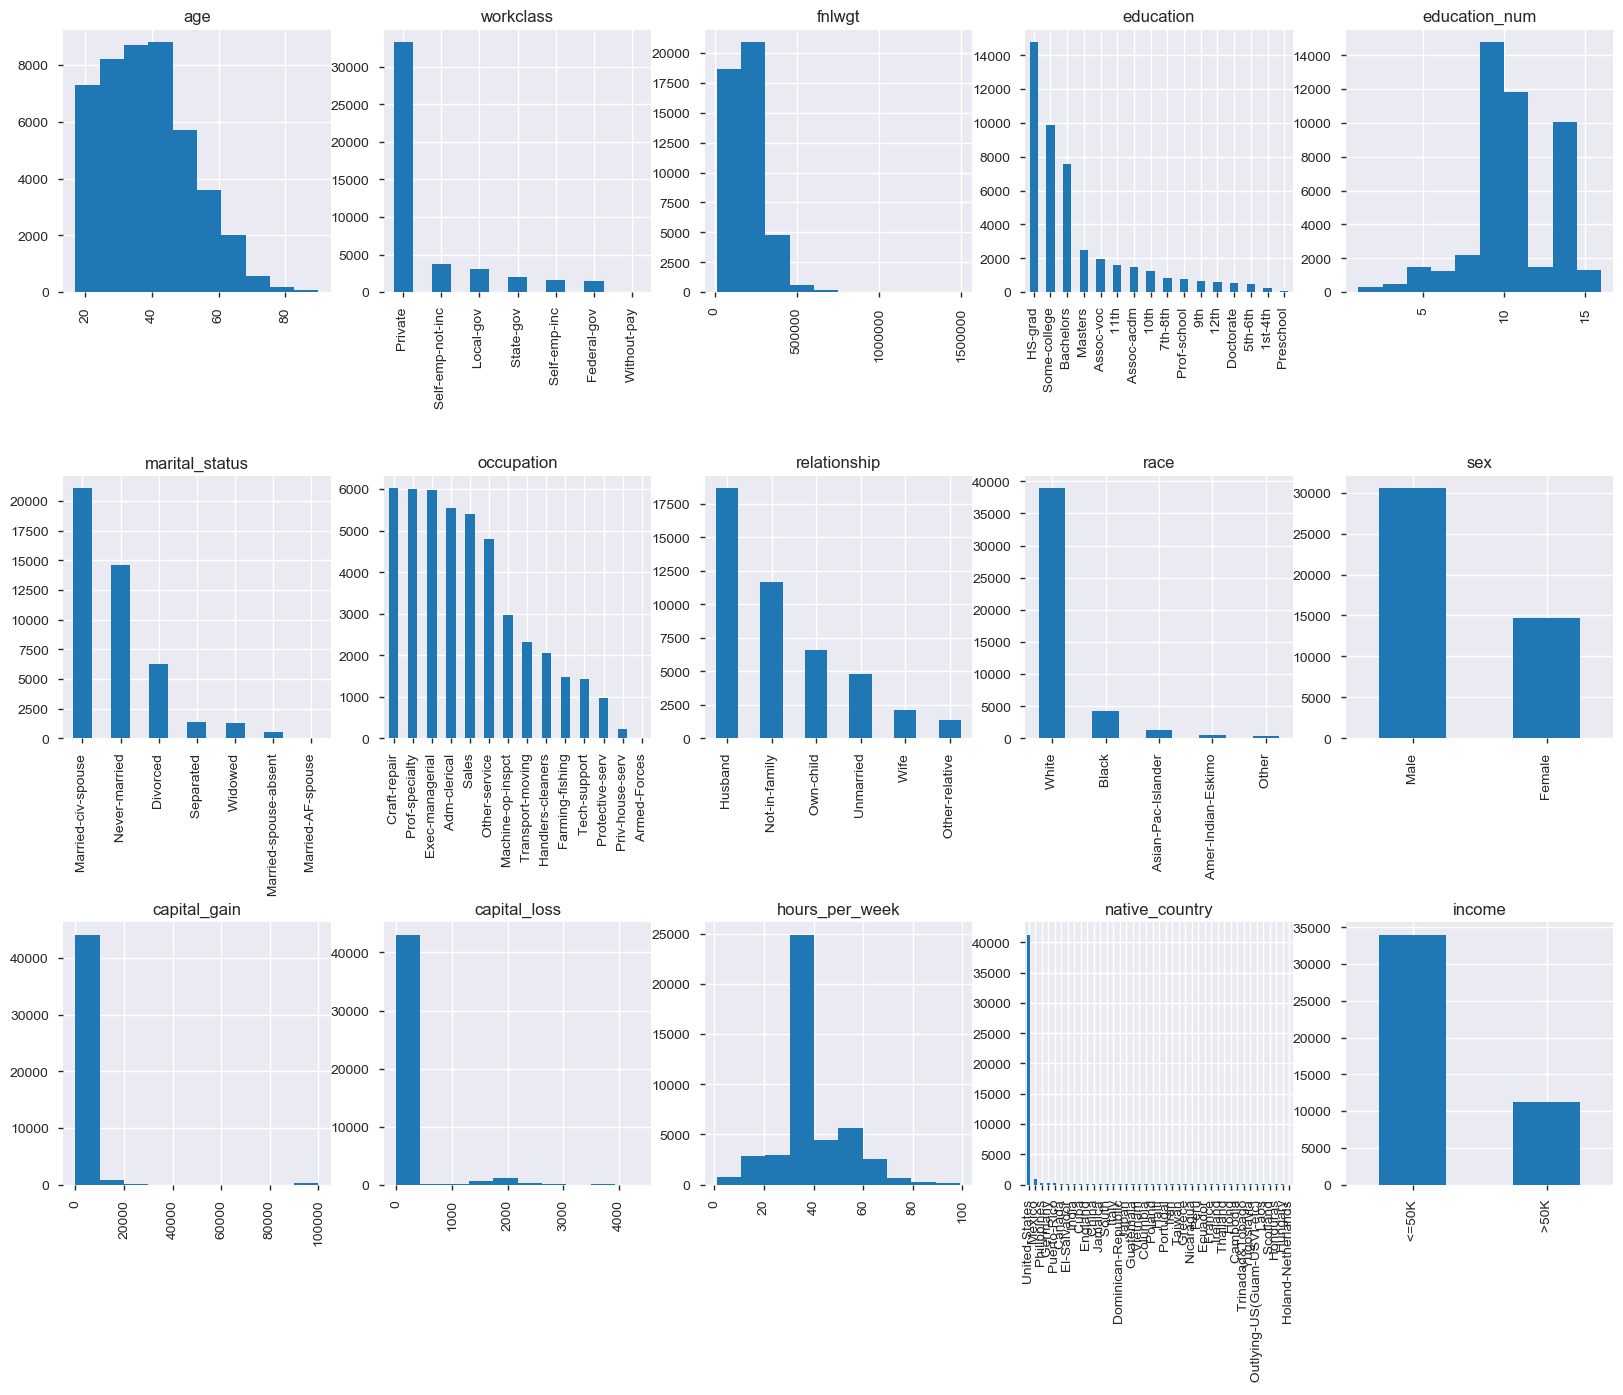

In [14]:
fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(df.shape[1]) / cols)
for i, column in enumerate(df.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if df.dtypes[column] == np.object:
        df[column].value_counts().plot(kind="bar", axes=ax)
    else:
        df[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 16280
Data columns (total 15 columns):
age               45222 non-null int64
workclass         45222 non-null object
fnlwgt            45222 non-null int64
education         45222 non-null object
education_num     45222 non-null int64
marital_status    45222 non-null object
occupation        45222 non-null object
relationship      45222 non-null object
race              45222 non-null object
sex               45222 non-null object
capital_gain      45222 non-null int64
capital_loss      45222 non-null int64
hours_per_week    45222 non-null int64
native_country    45222 non-null object
income            45222 non-null object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB


In [16]:
# Loop through all columns in the dataframe replacing strings values with an integer
for i in df.columns: 
    if df[i].dtype == 'object': 
        df[i] = pd.Categorical(df[i]).codes; 
        
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 16280
Data columns (total 15 columns):
age               45222 non-null int64
workclass         45222 non-null int8
fnlwgt            45222 non-null int64
education         45222 non-null int8
education_num     45222 non-null int64
marital_status    45222 non-null int8
occupation        45222 non-null int8
relationship      45222 non-null int8
race              45222 non-null int8
sex               45222 non-null int8
capital_gain      45222 non-null int64
capital_loss      45222 non-null int64
hours_per_week    45222 non-null int64
native_country    45222 non-null int8
income            45222 non-null int8
dtypes: int64(6), int8(9)
memory usage: 2.8 MB


In [17]:
#split df back into the original train/test sizes
train = df[:train_df.shape[0]]
test = df[train_df.shape[0]:]

## Train and Fine Tuning on the model

In [18]:
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from datetime import datetime
import xgboost as xgb

In [19]:
y_train = train.pop('income')
y_test = test.pop('income')
X_train = train
X_test = test

In [20]:
Model = [
        #GLM
    LogisticRegression(),
        
    #Trees    
    DecisionTreeClassifier(),
    ExtraTreesClassifier(),
    
    # support vector classifier
    SVC(),
    
    GaussianNB(),
    
    # knn
    KNeighborsClassifier(),
    
    #Ensamble
    RandomForestClassifier(),
    AdaBoostClassifier(),
    BaggingClassifier(),
    
    #Gradiend boosting
        #SGDClassifier(),
    xgb.XGBClassifier()
 
    ]

In [21]:
Model_list = []
Model_comparison = pd.DataFrame(columns = Model_list)


row_index = 0
for alg in Model:
    
    
    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = metrics.roc_curve(y_test, predicted)
    Model_name = alg.__class__.__name__
    Model_comparison.loc[row_index,'Model Name'] = Model_name
    Model_comparison.loc[row_index, 'Model Train Accuracy'] = round(alg.score(X_train, y_train), 4)
    Model_comparison.loc[row_index, 'Model Test Accuracy'] = round(alg.score(X_test, y_test), 4)
    Model_comparison.loc[row_index, 'Model Precission'] = metrics.precision_score(y_test, predicted)
    Model_comparison.loc[row_index, 'Model Recall'] = metrics.recall_score(y_test, predicted)
    Model_comparison.loc[row_index, 'Model AUC'] = metrics.auc(fp, tp)





    row_index+=1
    
Model_comparison.sort_values(by = ['Model Test Accuracy'], ascending = False, inplace = True)    
Model_comparison

,Model Name,Model Train Accuracy,Model Test Accuracy,Model Precission,Model Recall,Model AUC
9,XGBClassifier,0.8632,0.8616,0.792043,0.591892,0.770638
7,AdaBoostClassifier,0.8583,0.8556,0.760506,0.601622,0.769957
8,BaggingClassifier,0.9878,0.8454,0.728667,0.590811,0.759578
6,RandomForestClassifier,0.9876,0.8416,0.726646,0.569730,0.749962
2,ExtraTreesClassifier,1.0000,0.8290,0.684990,0.562432,0.739095
1,DecisionTreeClassifier,1.0000,0.8003,0.590258,0.612432,0.736982
4,GaussianNB,0.7885,0.7885,0.646557,0.307027,0.626181
0,LogisticRegression,0.7868,0.7863,0.641554,0.294595,0.620493
5,KNeighborsClassifier,0.8317,0.7677,0.545951,0.324324,0.618236
3,SVC,0.9985,0.7548,0.640000,0.004324,0.501766


In [22]:
# grid search xgboost

cv_params = {'max_depth': range(3,16,2), 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
gridXgboost= GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1)

In [23]:
gridXgboost.fit(X_train, y_train)
gridXgboost.cv_results_

{'mean_fit_time': array([22.1736259 , 21.52874513, 20.50987401, 30.98719268, 30.72046947,
        31.02749958, 43.2229125 , 42.65932479, 41.76672974, 55.23376336,
        53.48732576, 52.84927526, 67.62590809, 65.91692548, 64.34325662,
        79.95315595, 78.01401024, 76.65402789, 91.34408669, 86.0639699 ,
        69.24294004]),
 'std_fit_time': array([0.22202195, 0.72275091, 0.16455149, 0.17132215, 0.31626312,
        0.2895801 , 0.47538581, 0.3516594 , 0.31568777, 0.35751482,
        0.23125345, 0.07199145, 0.37943032, 0.34801242, 0.19731033,
        0.63909078, 0.67226841, 0.40765547, 0.74612976, 1.72701019,
        6.65686226]),
 'mean_score_time': array([0.32804947, 0.34054632, 0.32492456, 0.61235795, 0.59074841,
        0.54128027, 0.93728209, 0.90291548, 0.78106151, 1.45902238,
        1.49339156, 1.22470536, 1.80713367, 1.87767258, 1.51176815,
        2.17181239, 2.17217698, 1.5092793 , 2.50406017, 1.84055166,
        1.05547037]),
 'std_score_time': array([0.00988121, 0.02499

In [24]:
# Create our DMatrix to make XGBoost more efficient
xgdmat = xgb.DMatrix(X_train, y_train)

In [25]:
params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 

cv_xgb = xgb.cv(params = params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['error'],
                # Look for early stopping that minimizes error
                early_stopping_rounds = 100)

In [26]:
cv_xgb.tail(5)

,train-error-mean,train-error-std,test-error-mean,test-error-std
454,0.116703,0.001380,0.130296,0.004927
455,0.116736,0.001371,0.130230,0.004900
456,0.116620,0.001425,0.130197,0.004890
457,0.116579,0.001337,0.130130,0.004807
458,0.116479,0.001381,0.130097,0.004895


In [27]:
#final model
params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 
xgbModel= xgb.train(params, xgdmat, num_boost_round = 432)

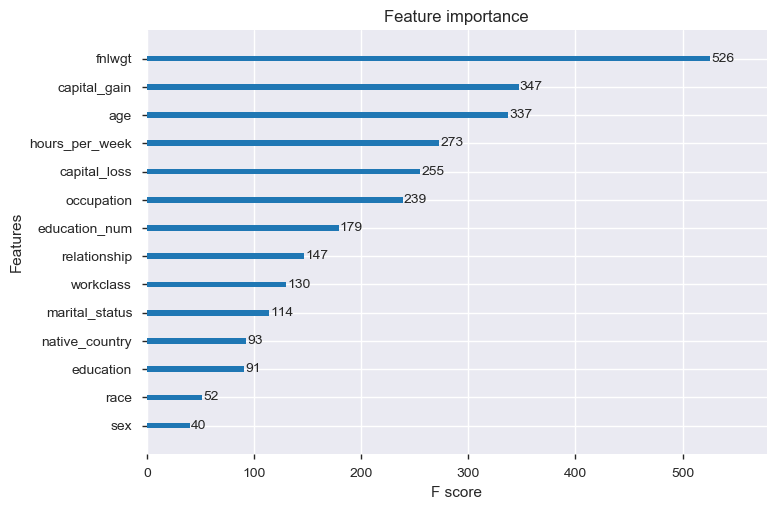

In [28]:
#feature importances
xgb.plot_importance(xgbModel)

## Analyze Performance on Test Data

In [29]:
"""
The model has now been tuned using cross-validation grid search 
through the sklearn API and early stopping through the built-in XGBoost API. 
Now, lest's see how it finally performs on the test set.  
We begin by creating a DMatrix for the test data
"""

testdmat = xgb.DMatrix(X_test)

In [30]:
from sklearn.metrics import accuracy_score

y_pred = xgbModel.predict(testdmat) 
display(y_pred)

array([0.00335308, 0.20390356, 0.25814337, ..., 0.8506804 , 0.14708076,
       0.8115065 ], dtype=float32)

In [31]:
"""
we need to convert the values of y_pred to 0/1 labels inorder to be able to calculate accuracy.
Set 0.5 probability as our threshold
"""

y_pred = np.rint(y_pred)
y_pred

array([0., 0., 0., ..., 1., 0., 1.], dtype=float32)

In [32]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92     11360
           1       0.78      0.66      0.71      3700

    accuracy                           0.87     15060
   macro avg       0.84      0.80      0.81     15060
weighted avg       0.87      0.87      0.87     15060

